In [8]:
# Importing packages
import matplotlib.pyplot as plt # seams to be the most used
import matplotlib as mpl # did not dare to mess with plt comand
#plt.style.use('ggplot')
import seaborn as sns
# sns.set(style='whitegrid')
#sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.lines as mlines
import matplotlib.ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.dates as mdates
from matplotlib import dates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
#import plotnine as p9 # Same as ggplot
import pandas as pd
import numpy as np
import math
from scipy.signal import medfilt
import scipy.stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import glob
import re


# To get untruncated output from pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Normal Setting global font size for plots
plt.rcParams['font.sans-serif'] = 'Arial'
small_size = 12
medium_size = 14
large_size = 16
plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
plt.rc('legend',fontsize=medium_size)      # fontsize of the legend'
plt.rcParams['axes.xmargin'] = 0         # get rid of margins befor and after data along x-axis
# plt.rcParams["axes.grid"] = False     # remove grid of plots

# remove grid but keep tick marks for the axes
color = 'black'
plt.rc('axes', grid=False, edgecolor=color)
plt.rc('xtick', bottom=True, top=False, color=color)  # Show bottom ticks and hide top ticks for all plots
plt.rc('ytick', left=True, right=False, color=color)  # Show left ticks and hide right ticks for all plots
plt.rc('xtick', labelcolor=color)  # Set x tick label color to black
plt.rc('ytick', labelcolor=color)

colors= ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00','#000000','#BBBBBB'] # https://nanx.me/oneclust/reference/cud.html

# # POSTER Setting global font size for plots
# medium_size = 26
# large_size = 30
# plt.rc('axes', titlesize=large_size)     # fontsize of the axes title
# plt.rc('axes', labelsize=large_size)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=medium_size)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=medium_size)    # fontsize of the tick labels
# plt.rc('legend',fontsize=medium_size)      # fontsize of the legend'
# plt.rcParams['axes.xmargin'] = 0         # get rid of margins befor and after data along x-axis


# LOADING FUNCTIONS
def sub_sample_df_old(df, moduleMask): # insert dataframe and mask for dataframe
    modules = df[moduleMask]
    if 'Displacement [mm]:' in df.columns:
        subSample = modules[['Date:', 'Displacement [mm]:']]
    if 'Water table [m bgl]:' in df.columns:
        subSample = modules[['Date:', 'Module ID:', 'Water table [m bgl]:']]
    subSample = subSample.set_index('Date:')
    return subSample

# SUBSAMPLING DF's       NEW
def sub_sample_df(df, modules): # insert dataframe and mask for dataframe
    khlist = []
    modules = modules
    for i in modules:
        file = df
        module = i
        moduleMask = file['Module ID:'].isin([module])
        file = file[moduleMask]
        file.set_index('Date:', inplace=True)
        file = file.resample('1h').median()    
        khlist.append(file) # adding modules to list
    df = pd.concat(khlist, axis=1)
    
    # inclinometers
    if 'Displacement [mm]:' in df.columns:
        subSample = df[['Displacement [mm]:']]
    
    # piezometers
    if 'Water table [m bgl]:' in df.columns:
        subSample = df[['Water table [m bgl]:']]
    
    return subSample

# Slice df by time_start and time_end 
def sub_set_df(df, time_start=1, time_end=2):
    mask = (df.index > time_start) & (df.index <= time_end)
    return df[mask]

# # Statsmodel, linear regression over n hours defined by window_hours
# from statsmodels.formula.api import ols
# def linearfit(volume, window_days=0.5, results = False, gps=False):
#     volume = volume.to_frame()
#     df = volume.dropna()
#     df = df.reset_index(drop=True) # due to LinearRgression is not able to calculate with dateformat as x-axis
#     if gps is True:
#         window_hours = 2*window_days
#     else:
#         window_hours = 24*window_days 
#     cutoff_start = df.index.values[0]
#     cutoff_end = cutoff_start + window_hours
#     reg_res = []
#     data_left = True

#     # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
#     while data_left:
#         if cutoff_end > df.index.values[-1]:
#             data_left = False
#             cutoff_end = df.index.values[-1]
#             break   
#         start = df.index.values >= cutoff_start
#         end = df.index.values <= cutoff_end
#         current_data = df[start & end]
#         if len(current_data) > window_hours-1:
#             mod = sm.OLS(y, sm.add_constant(X))
#             mod = ols(formula = 'current_data.values ~ current_data.index', data = current_data) # model
#             fit = mod.fit() # model fit
#             if results is True:
#                 reg_res += [(cutoff_start+window_hours//2, fit.params[1], fit.params[0], fit.rsquared)]  # returns intercept and r^2 in addition to index and slope
#             else:
#                 reg_res += [(cutoff_start+window_hours//2, fit.params[1])]  # returns index and slope
#         cutoff_start += 1
#         cutoff_end = cutoff_start + window_hours

#     # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
#     df.index.name = 'index'
#     df[volume.index.name] = volume.index
#     slopedf = pd.DataFrame(reg_res)
#     if results is True:
#         slopedf.columns = ['index',f'{window_days}_days_velocity', 'intercept', 'r^2'] # NB velocity is the slope of the fit
#         slopedf['y_fit'] = slopedf[f'{window_days}_days_velocity']*slopedf.index+slopedf['intercept']
#         df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
#         df_merged.set_index(volume.index.name,inplace=True, drop=True)
#         df_merged['residuals'] = (df_merged.iloc[:,[1]].values-df_merged.iloc[:,[5]].values) # y-y_hat = resuduals
#         df_merged['error_of_fit'] = ((np.mean(df_merged['residuals']**2))**(1/2))
#         df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna()
#     else:
#         slopedf.columns = ['index',f'{window_days}_days_velocity']
#         df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
#         df_merged.set_index(volume.index.name,inplace=True, drop=True)
#         df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna()

# NEW VERSION !

# Statsmodel, linear regression over n hours defined by window_hours
from statsmodels.formula.api import ols
def linearfit(volume, window_days=0.5, results = False, gps=False): # added gps= to get rows that fit gps days velocity
    volume = volume.to_frame()
    df = volume.copy()
    df = df.reset_index(drop=True) # due to LinearRgression is not able to calculate with dateformat as x-axis
    if gps is True:
        window_hours = 2*window_days
    else:
        window_hours = 24*window_days 
    cutoff_start = df.index.values[0]
    cutoff_end = cutoff_start + window_hours
    reg_res = []
    data_left = True # starts loop

    # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
    while data_left:
        if cutoff_end > df.index.values[-1]:
            data_left = False # stops loop
            cutoff_end = df.index.values[-1]
            break   
        start = df.index.values >= cutoff_start
        end = df.index.values <= cutoff_end
        current_data = df[start & end]
        current_data = current_data.squeeze()
        # added part so no need of interpolation, but perhaps for boreholes?
        if max(current_data.isnull().astype(int).groupby(current_data.notnull().astype(int).cumsum()).cumsum()) > window_hours/4: # True if more than consecutive nans
            current_data = current_data.dropna(axis=0) # deletes nan so df is to small to get true in next if statement
        
        if len(current_data) > window_hours-1:
            mod = ols(formula = 'current_data.values ~ current_data.index', data = current_data) # model
            fit = mod.fit() # model fit
            if results is True:
                reg_res += [(cutoff_start+window_hours//2, fit.params[1], fit.params[0], fit.rsquared)]  # returns intercept and r^2 in addition to index and slope
            else:
                reg_res += [(cutoff_start+window_hours//2, fit.params[1])]  # returns index and slope
        cutoff_start += 1
        cutoff_end = cutoff_start + window_hours

    # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
    df.index.name = 'index'
    df[volume.index.name] = volume.index
    slopedf = pd.DataFrame(reg_res)
    if results is True:
        slopedf.columns = ['index',f'{window_days}_days_velocity', 'intercept', 'r^2'] # NB velocity is the slope of the fit
        slopedf['y_fit'] = slopedf[f'{window_days}_days_velocity']*slopedf.index+slopedf['intercept']
        df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
        df_merged.set_index(volume.index.name,inplace=True, drop=True)
        df_merged['residuals'] = (df_merged.iloc[:,[1]].values-df_merged.iloc[:,[5]].values) # y-y_hat = resuduals
        df_merged['error_of_fit'] = ((np.mean(df_merged['residuals']**2))**(1/2))
        df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna() # this might be a problem in the future.. But I will comment it and get data with nans
        return df_merged
    else:
        slopedf.columns = ['index',f'{window_days}_days_velocity']
        df_merged = pd.merge_asof(df,slopedf, on=df.index.name, tolerance=0)
        df_merged.set_index(volume.index.name,inplace=True, drop=True)
        df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
#         return df_merged.dropna() # this might be a problem in the future.. But I will comment it and get data with nans
        return df_merged
    
# cross correlation and its p-value
def pearsonr_crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method='pearson')

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def pearsonr_crosscorr_pval(datax, datay, lag=0):
    return datax.corr(datay.shift(lag), method=pearsonr_pval)

def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# STA/LTA FILTER WITH CREEP BURST THRESHOLD 
def sta_lta(df, STA=2, LTA=60, detrigg_on=True, trigg=2, detrigg=1, threshold_dynamic=True):
    df = pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=LTA), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    
    # add STA if it is not in the df
    if not f'{STA}_days_velocity' in df.columns:
        df.set_index(df.columns[0], drop=True, inplace=True)
        df = pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=STA), on=df.index.name, tolerance=pd.Timedelta(hours=0))
    
    # setting STA and LTA 
    df['sta'] = df[f'{STA}_days_velocity'].values # use 1_day or 2_days ?
    df['lta'] = df[f'{LTA}_days_velocity'].values
#     df.loc[:, 'lta'] = df[f'{LTA}_days_velocity'].shift(LTA*24//2) # shifts lta to start at end of window, not middle. This was used in seismology but did not seam to work as well on our time series
    df['sta/lta'] = df['sta']/df['lta']
    
    # creep burst threshold
    df['trigger'] = np.nan
    df['detrigger'] = np.nan
    
    if threshold_dynamic is True:
        # dynamic threshold
        window_length = LTA*24 # the start of mean calculation
        for i,d in enumerate(df['sta/lta'][window_length+window_length//2:-window_length//2]):
            # window from start to end of sta/lta
            window = df.loc[i+window_length:i+window_length*2, 'sta/lta']
            sigma = np.sqrt((np.sum(np.square(window-np.mean(window))))/len(window-1))
            # inserting mean + sigma in center of window
            df.loc[i+window_length+window_length//2, 'trigger'] = np.mean(window)+sigma*trigg # 2 x SD centered 
            df.loc[i+window_length+window_length//2, 'detrigger'] = np.mean(window)+sigma*detrigg # 1 x SD centered
    else:
        # static threshold
        sigma = np.sqrt((np.sum(np.square(df['sta/lta']-np.mean(df['sta/lta']))))/len(df['sta/lta']-1))
        df['trigger'] = np.mean(df['sta/lta'])+sigma*trigg
        df['detrigger'] = np.mean(df['sta/lta'])+sigma*detrigg
    
    # selecting creep bursts
    df['nBursts'] = 0
    prev_d = 0
    prev_burst_idx = 0
    indexes = []
    above_trigg = False
    
    if detrigg_on is True:
        for i, d in enumerate(df['sta/lta']):
            # trigger threshold
            if d > df.loc[i, 'detrigger']:
                indexes += [i]
                if d > df.loc[i, 'trigger']:
                    above_trigg = True
            else:
                if above_trigg:
                    df.loc[indexes, 'nBursts'] = 1
                indexes = []
                above_trigg = False
    df.set_index(df.columns[0], drop=True, inplace=True)
    return df

def velocity(df, window_days=4, results=True):
    df =  pd.merge_asof(df, linearfit(df['displacement_butterfilt'], window_days=window_days, results=results), on=df.index.name, tolerance=pd.Timedelta(hours=0)) #results=True to get additional results
    df.set_index(df.columns[0], drop=True, inplace=True) # reinsetting the datetime index
    return df

# When agreed on how it should look like, make this a part of the pre_plotting script

def creep_database(df, STA):
    
    # time resolution
    hours = 60*60 # in hours
    days = hours*24 # in days

    # fetching creep events
    window = []
    previous_d = 0
    for i, d in enumerate(df['nBursts']):
            if d != previous_d:
                previous_d = d
                window.append(df.index[i:i+1])
    # creating database of creep bursts
    idx = np.arange(0, len(window), 2)  # index to slice at even numbers
    idx2 = np.arange(0, len(idx), 1)

    creep_database = pd.DataFrame(idx2, columns=['event']) # length of df
    date_start = []
    date_end = []
    duration = []
    duration_days = []
    date = []
    displacement_start = []
    displacement = []
    velocity = []
    velocity_days = []
    slip_distance = []

    # loading each event and saving data to database
    for start in idx:
        creep_event = df.loc[window[start][0]:window[start+1][0]] # the last row in df is not part of creep burst event
        date_start.append(creep_event.index[0])
        date_end.append(creep_event.index[-1])
        duration.append((creep_event.index[-1]-creep_event.index[0]).total_seconds()//hours) # duration in hours
        duration_days.append((creep_event.index[-1]-creep_event.index[0]).total_seconds()//days) # duration in days
        date.append((creep_event.index[:-1]-creep_event.index[0]).total_seconds()//hours) # to be able to plot each event
        displacement_start.append(creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # to make plotting on top of entire dataseries easier
        displacement.append(creep_event['displacement_butterfilt'][:-1].values-
                            creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # to be able to plot each event
        slip_distance.append(creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].last_valid_index()]-
                             creep_event['displacement_butterfilt'][creep_event['displacement_butterfilt'].first_valid_index()]) # total displacement
        velocity.append(np.nanmax(creep_event[f'{STA}_days_velocity'][:-1])) # max velocity for 'n_days_velocity' per day

    creep_database['date_start'] = date_start
    creep_database['date_end'] = date_end
    creep_database['duration'] = duration
    creep_database['date'] = date # to be able to plot each event
    creep_database['displacement_start'] = displacement_start # to be able to plot each event ontop of entire timeseries
    creep_database['displacement'] = displacement # to be able to plot each event
    creep_database['total_slip_distance'] = slip_distance
    creep_database['max_velocity'] = velocity
#     # the below are for the creep database plots in days
    creep_database['duration_days'] = duration_days 
    creep_database['nEvents'] = 1
    
    return creep_database


# function to sum for two months (window_days). Used for seismics and surface runoff
def sum_period(volume, window_days=60):
    volume = volume.to_frame()
    window_hours = 24*window_days
    df = volume.copy()
    df = df.reset_index(drop=True)
    cutoff_start = df.index.values[0]
    cutoff_end = cutoff_start + window_hours
    summed_data = []
    data_left = True # starts loop

    # Slicing timeseries by window_hours calculating linear regression with slope, intercept and r^2                                                                           
    while data_left:
        if cutoff_end > df.index.values[-1]:
            data_left = False # stops loop
            cutoff_end = df.index.values[-1]
            break   
        start = df.index.values >= cutoff_start
        end = df.index.values <= cutoff_end
        current_data = df[start & end]
        current_data = current_data.squeeze()

        if max(current_data.isnull().astype(int).groupby(current_data.notnull().astype(int).cumsum()).cumsum()) > window_hours/4: # True if more than consecutive nans
                current_data = current_data.dropna(axis=0) # deletes nan so df is to small to get true in next if statement

        if len(current_data) > window_hours-1:
            summed = current_data.sum()
            summed_data += [(cutoff_start+window_hours//2, summed)]  # returns index and summation of events in the time window, 1 month before and after, so centered
        cutoff_start += 1
        cutoff_end = cutoff_start + window_hours

    # Merging df and reg_res to obtain correct index and storing output from linear regression and calculating error of fit
    df.index.name = 'index'
    df[volume.index.name] = volume.index # make same name for both indexes to be able to merge on name
    new_df = pd.DataFrame(summed_data)

    new_df.columns = ['index',f'{window_days}_days_summed']
    df_merged = pd.merge_asof(df,new_df, on=df.index.name, tolerance=0)
    df_merged.set_index(volume.index.name,inplace=True, drop=True)
    df_merged.drop(df_merged.columns[[0,1]], axis=1, inplace=True)
    return df_merged

def reindexing_1h(df):
    idx = pd.date_range(start=df.index[0],end=df.index[-1],freq='1h')
    df = df.reindex(idx)
    return df

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

Number of colors 11


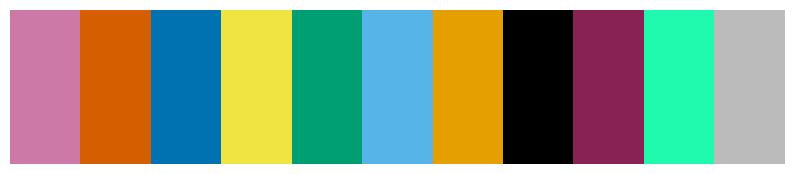

In [9]:
# creating a color palette for color blind mode
colors= ['#CC79A7','#D55E00','#0072B2','#F0E442','#009E73','#56B4E9','#E69F00','#000000', '#882255', '#20FAAE','#BBBBBB'] # https://nanx.me/oneclust/reference/cud.html
print('Number of colors', len(colors))
# Convert the color names to RGB
from matplotlib import colors as color_to_rgb
rgb_colors = [color_to_rgb.to_rgba(color) for color in colors]

# Create a plot to display the colors
plt.figure(figsize=(10, 2))  # Adjust the size if needed
plt.imshow([rgb_colors], aspect='auto')  # Use aspect='auto' to stretch the colors across the axis
plt.axis('off')  # Hide axis
plt.show()

# Loading data

In [10]:
path = 'pre_plotting\\'  # set folder related to script location

extension = '.pkl'

## GPS
# 12 hour data
jtt_gps2 = pd.read_pickle(path + 'jett_gps_2' + extension)
jtt_gps3 = pd.read_pickle(path + 'jett_gps_3' + extension)
jtt_gps4 = pd.read_pickle(path + 'jett_gps_4' + extension)
jtt_gps5 = pd.read_pickle(path + 'jett_gps_5' + extension)
jtt_gps6 = pd.read_pickle(path + 'jett_gps_6' + extension)
jtt_gps7 = pd.read_pickle(path + 'jett_gps_7' + extension)
jtt_gps8 = pd.read_pickle(path + 'jett_gps_8' + extension)
jtt_gps9 = pd.read_pickle(path + 'jett_gps_9' + extension)
jtt_gps10 = pd.read_pickle(path + 'jett_gps_10' + extension)
jtt_gps11 = pd.read_pickle(path + 'jett_gps_11' + extension)

gam_gps3 = pd.read_pickle(path + 'gam_gps_3' + extension)
gam_gps4 = pd.read_pickle(path + 'gam_gps_4' + extension)
gam_gps5 = pd.read_pickle(path + 'gam_gps_5' + extension)
gam_gps6 = pd.read_pickle(path + 'gam_gps_6' + extension)
gam_gps7 = pd.read_pickle(path + 'gam_gps_7' + extension)
gam_gps8 = pd.read_pickle(path + 'gam_gps_8' + extension)
gam_gps9 = pd.read_pickle(path + 'gam_gps_9' + extension)
gam_gps10 = pd.read_pickle(path + 'gam_gps_10' + extension)

# # ak_gps4 = pd.read_pickle(path + 'ak_gps_4' + extension)
# # ak_gps5 = pd.read_pickle(path + 'ak_gps_5' + extension)

# # # 4 hour data
# # gps3_4h = pd.read_pickle(path + 'gps3_4h' + extension)
# # gps4_4h = pd.read_pickle(path + 'gps4_4h' + extension)

## Meteorological data from Senorge (real data) and XGEO (Modeled weather data that is better than the cautus weather station)
# Jettan
jtt_xgeo_rain = pd.read_pickle(path + 'jett_xgeo_precip' + extension) 
jtt_xgeo_temp = pd.read_pickle(path + 'jett_xgeo_temp' + extension)
jtt_xgeo_snow = pd.read_pickle(path + 'jett_xgeo_snow' + extension)
jtt_temp = pd.read_pickle(path + 'jtt_temp' + extension)
jtt_precip = pd.read_pickle(path + 'jtt_precip' + extension)
jtt_snow = pd.read_pickle(path + 'jtt_snow' + extension)
jtt_xgeo_surfacerunnoff = pd.read_pickle(path + 'jett_xgeo_surfacerunnoff' + extension)
JT_CLM_1_2 = pd.read_pickle(path + 'JT_CLM_1_2' + extension)
ST = pd.read_pickle(path + 'ST' + extension)
tlt2_temp = pd.read_pickle(path + 'tlt2_temp' + extension)
tlt9_temp = pd.read_pickle(path + 'tlt9_temp' + extension)
hobos = pd.read_pickle(path + 'hobos' + extension)
temp1 = pd.read_pickle(path + 'temp1' + extension)

# Gamanjunni
gam_temp = pd.read_pickle(path + 'gam_temp' + extension)
gam_precip = pd.read_pickle(path + 'gam_precip' + extension)
gam_xgeo_precip = pd.read_pickle(path + 'gam_xgeo_precip' + extension)
gam_xgeo_temp = pd.read_pickle(path + 'gam_xgeo_temp' + extension)
gam_xgeo_snow = pd.read_pickle(path + 'gam_xgeo_snow' + extension)
gam_xgeo_surfacerunnoff = pd.read_pickle(path + 'gam_xgeo_surfacerunnoff' + extension)

# river data measurements
river1 = pd.read_pickle(path + 'river1' + extension)
river2 = pd.read_pickle(path + 'river2' + extension)

# ## Borholes
# Raw is without filtered and without raw is filtered
# Jettan
JTT1Disp = pd.read_pickle(path + 'JTT1Disp_raw' + extension)
JTT1Wp = pd.read_pickle(path + 'JTT1Wp_raw' + extension)

JTT2DispUpperZone = pd.read_pickle(path + 'JTT2DispUpperZone_raw' + extension)
JTT2WpUpperZone = pd.read_pickle(path + 'JTT2WpUpperZone_raw' + extension)

JTT2DispLowerZone = pd.read_pickle(path + 'JTT2DispLowerZone_raw' + extension)
JTT2WpLowerZone = pd.read_pickle(path + 'JTT2WpLowerZone_raw' + extension)

JTT3Disp = pd.read_pickle(path + 'JTT3Disp_raw' + extension)
JTT3Wp = pd.read_pickle(path + 'JTT3Wp_raw' + extension)

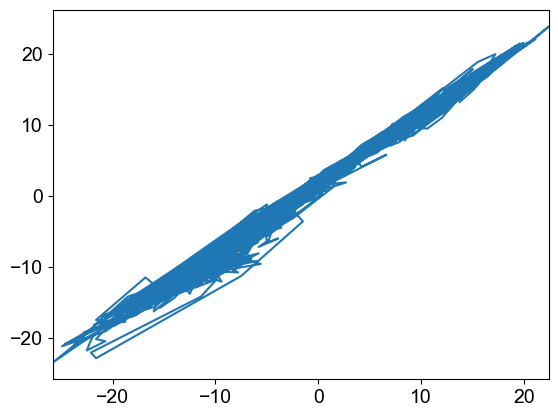

In [3]:
plt.plot(gam_xgeo_temp.iloc[:,0], jtt_xgeo_temp.iloc[:,0])

# Overview

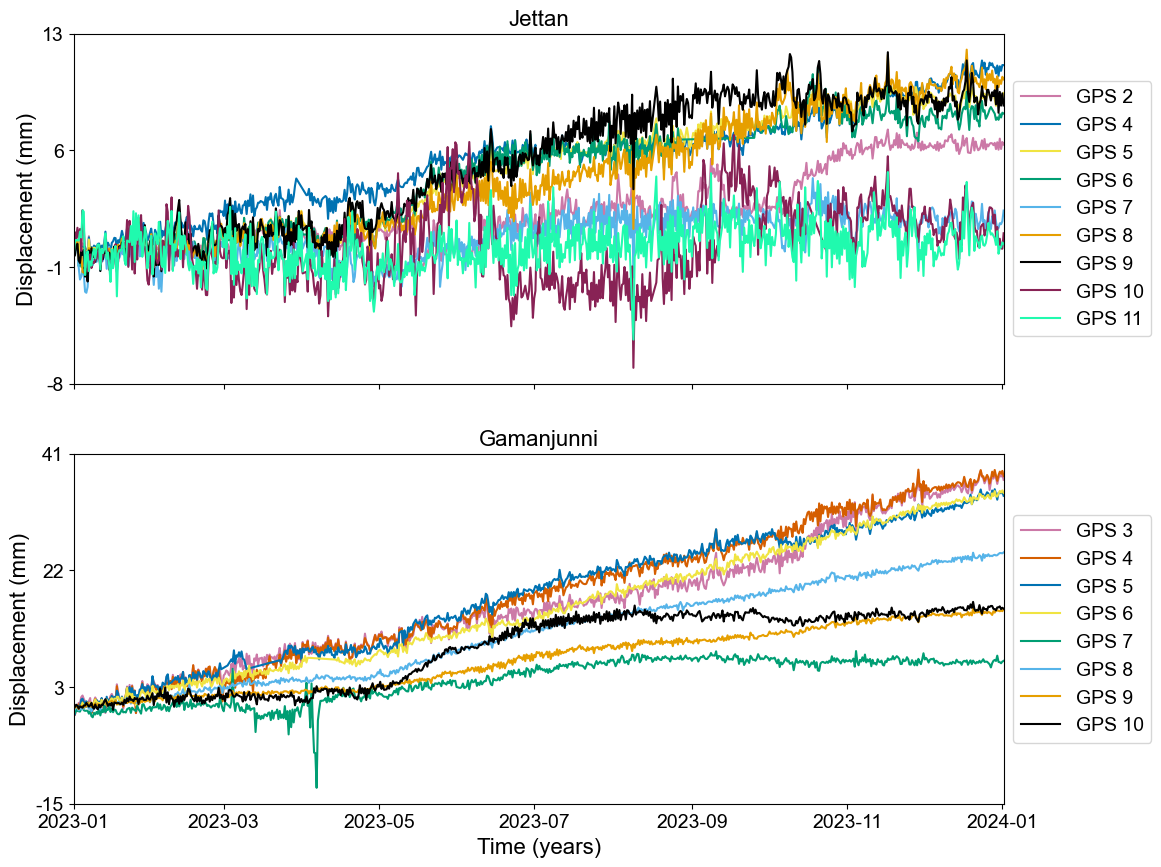

In [23]:
## TO LOOK AT GNSS VELOCITY og Jettan vs Gamanjunni to see seasonal trends

from matplotlib.dates import DateFormatter

# manually picked start and end times for following data

# plotting

ncols = 1
nrows = 2 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
# fig.subplots_adjust(hspace = .2, wspace=.6)

start_time = '2023-01-01'
end_time = '2024-01-01'

data = '2d'

#JETTAN
df =  jtt_gps2
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[0], label='GPS 2')

# df =  jett_gps3
# df =  df[df.index.slice_indexer(start_time,end_time)]
# df.index = pd.to_datetime(df.index)
# idx = df.first_valid_index()
# df = df.replace(np.nan,np.inf) # changing nan to inf
# ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[1], label='GPS 3')

df =  jtt_gps4
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[2], label='GPS 4')

df =  jtt_gps5
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[3], label='GPS 5')

df =  jtt_gps6
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index,(df[data]-df[data][idx]), color=colors[4], label='GPS 6')

df =  jtt_gps7
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[5], label='GPS 7')

df =  jtt_gps8
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[6], label='GPS 8')

df =  jtt_gps9
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[7], label='GPS 9')

df =  jtt_gps10
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index,(df[data]-df[data][idx]), color=colors[8], label='GPS 10')

df =  jtt_gps11
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[0].plot(df.index, (df[data]-df[data][idx]), color=colors[9], label='GPS 11')

# GAMANJUNNI
df =  gam_gps3
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[0], label='GPS 3')

df =  gam_gps4
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[1], label='GPS 4')

df =  gam_gps5
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[2], label='GPS 5')

df =  gam_gps6
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[3], label='GPS 6')

df =  gam_gps7
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[4], label='GPS 7')

df =  gam_gps8
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[5], label='GPS 8')

df =  gam_gps9
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[6], label='GPS 9')

df =  gam_gps10
df =  df[df.index.slice_indexer(start_time,end_time)]
df.index = pd.to_datetime(df.index)
idx = df.first_valid_index()
df = df.replace(np.nan,np.inf) # changing nan to inf
ax[1].plot(df.index, (df[data]-df[data][idx]), color=colors[7], label='GPS 10')

nticks = 4
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.f'))

# ymin, ymax = ax[0].get_ylim()
# ax[0].set_ylim(0, 40)

# ymin, ymax = ax[1].get_ylim()
# ax[1].set_ylim(0, 120)

# title
ax[0].set_title('Jettan')
ax[1].set_title('Gamanjunni')

# legend
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# set axis labels
ax[0].set_ylabel('Displacement (mm)')
ax[1].set_ylabel('Displacement (mm)')
ax[1].set_xlabel('Time (years)')
# n = 2  # Keeps every 2th label
# for i in range(nrows):
#     ax[i].xaxis.set_major_locator(mdates.YearLocator(1)) # tick every year
#     [l.set_visible(False) for (i,l) in enumerate(ax[i].xaxis.get_ticklabels()) if i % n != 0] # lable every other year

# # # saving
path = 'plots\\'
save_name = f'{path}GNSS_Displacement_Longterm_JETT_GAM'
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [44]:
#### time constraint  #####
start_time = pd.Timestamp('2013-01-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
end_time = pd.Timestamp('2025-01-01')

interval = '1D' # choose between 1D, 1W, 1M

# original data
a = gam_gps3.iloc[:,3] 
b = gam_gps4.iloc[:,3] 
x = gam_gps5.iloc[:,3]  
y = gam_gps6.iloc[:,3]  
z = gam_gps7.iloc[:,3] 
e = gam_gps8.iloc[:,3]  
f = gam_gps9.iloc[:,3] 
g = gam_gps10.iloc[:,3]

columns=['GPS-3', 'GPS-4', 'GPS-5', 'GPS-6', 'GPS-7','GPS-8', 'GPS-9', 'GPS-10']

df = pd.concat([a,b,x,y,z,e,f,g], axis=1)
df.columns =[columns]
df.dropna(inplace=True)
df = diff_shift(df, 1)
df.head()

                 GPS-3       GPS-4       GPS-5      GPS-6       GPS-7       GPS-8      GPS-9     GPS-10
time                                                                                                   
2020-10-02  179.711291  157.288269  136.684107  96.587749  541.944177  161.145065  53.073893  65.989506
2020-10-03  179.890353  157.261749  136.675018  96.773118  541.775850  161.365095  53.412576  66.534744
2020-10-04  180.433575  157.695451  136.485105  97.119125  541.760087  161.465052  53.378697  66.155343
2020-10-05  180.288181  157.327468  135.884312  96.667266  542.043079  161.430005  53.676057  66.135723
2020-10-06  180.141110  157.609822  136.571378  96.768410  541.582909  160.785370  53.052637  65.670156


,GPS-3,GPS-4,GPS-5,GPS-6,GPS-7,GPS-8,GPS-9,GPS-10
time,,,,,,,,
2020-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-10-03,0.179062,-0.026520,-0.009089,0.185369,-0.168327,0.220030,0.338683,0.545238
2020-10-04,0.543222,0.433702,-0.189913,0.346007,-0.015763,0.099957,-0.033879,-0.379401
2020-10-05,-0.145395,-0.367983,-0.600793,-0.451859,0.282993,-0.035047,0.297360,-0.019621
2020-10-06,-0.147071,0.282354,0.687066,0.101145,-0.460170,-0.644635,-0.623421,-0.465567


In [410]:
# differencing n rows to get seasonal and trend removed to obtain statinarity
from scipy.signal import savgol_filter

def diff_shift(df, nrow_shift):
    return df-df.shift(nrow_shift) # Takes nrow forwards in time minus 'current' row and gives difference

def norm(series):
    series = scaler.fit_transform(series.values.reshape(-1, 1)) # transform to normalized values
    # df = scaler.inverse_transform(df) # transform back to original
    return series.reshape(-1) # transform back to correct shape

from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    data = data.values # values to filter
    nyq = 0.5 * fs # Nyquist Frequency, assumes regular time intervals
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y
    
def clean_filt(file, col=0): # colnmbr is the column chosen to lowpass filter
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file['interpolated'] = file.iloc[:,col].interpolate(method='linear', limit_direction ='forward')
    # file['butterfilt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['savgol'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    return file


# values for the low pass filter
n = 3 # number of days cut off
fs = 1 # sample rate in hours 
cutoff = 1/(24*n) # 1/24 means cutoff at 1 day, but times nyquist frequncey so twice
order = 2 # line from 1 to 0, second order is perfect function

# median filter window
window_median = 15 # 7 might be okay and 29 is smooth, tried with 15 as a middle way to keep temp stationary

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3

#### time constraint  #####
start_time = pd.Timestamp('2019-01-01') # need as long as possible to make stationary, 2015 to 2018 is not enough
end_time = pd.Timestamp('2025-01-01')

interval = '1D' # choose between 1D, 1W, 1M

# original data
a = gam_gps3.iloc[:,3] 
b = gam_gps4.iloc[:,3] 
x = gam_gps5.iloc[:,3]  
y = gam_gps6.iloc[:,3]  
z = gam_gps7.iloc[:,3] 
e = gam_gps8.iloc[:,3]  
f = gam_gps9.iloc[:,3] 
g = gam_gps10.iloc[:,3]

columns=['GPS-3', 'GPS-4', 'GPS-5', 'GPS-6', 'GPS-7','GPS-8', 'GPS-9', 'GPS-10']

df = []
original_df = []
df = pd.concat([a,b,x,y,z,e,f,g], axis=1)
df.columns =[columns]
df = df.dropna()
original_df = df.copy()

# cleaned data
def clean_df(df,start_time,end_time, interval):
    df = df[df.index.slice_indexer(start_time,end_time)]
    df = df.resample('1D').median() # get same base interval to clean data on
    df = df.dropna()
    for i, col in enumerate(df.columns):
        df.loc[:,col] = clean_filt(df.loc[:,col]).values # filtered data
        # df.loc[:,col] = medfilt(df.loc[:,col], window_median) # median filter
        df.loc[:, col] = df.loc[:, col].rolling(window=window_mean, center=True).mean() # rolling mean
    return df

# First I do a savgol filter, then I do a rolling mean after that again. And then downsampling the smoothed data.

df = clean_df(original_df,start_time,end_time, interval)
if not interval=='1D':
    print(f'{interval} resampling')
    df = df.resample(interval).median() # downsampling with median value after cleaning
# df = diff_shift(df, 1) # velocity
df = df.dropna()

# To compare results to original data
original_df = original_df[original_df.index.slice_indexer(start_time,end_time)]
original_df = original_df.resample(interval).median()
# original_df = diff_shift(original_df, 1) # velocity
# original_df.dropna(inplace=True)

# Split into train and test
df_train = df.copy() # to keep entire df for prediction

# Apply decompose (decompose trend, seasonality, and resudials) to make data stationary
from statsmodels.tsa.seasonal import STL

df_list = []
for i,d in enumerate(df_train.columns):
    df = []
    original = df_train.loc[:,d] # data
    # seasonal decompositoon parameters
    if interval == '1M':
        seasonal = 13 # can try 7 to 13 from chatgpt, but need to test this to see what is correct
        period = 12 
    if interval == '1W':
        seasonal = 13 # can try 7 to 13 from chatgpt
        period = 52 
    if interval == '1D':
        seasonal = 13 # 7 to 25 from chatgpt
        period = 365 
    decomposed_series = STL(original, seasonal=seasonal, period=period).fit() # for daily should be 13 and 365
    trend = decomposed_series.trend
    seasonal = decomposed_series.seasonal
    residual = decomposed_series.resid
    df = pd.DataFrame({'original':original.values, 'trend': trend.values, 'seasonal':seasonal.values, 'residual':residual.values}, index=df_train.index) 
    df = df.dropna()
    
#     #### Comment this part out when finished looking at what series is stationary  ####
#     # correlating?
#     print(f'{d}')
#     # print(df.corr()) # correlations

#     #### testing stationarity ####
#     from statsmodels.tsa.stattools import adfuller
#     for i, variable in enumerate(df.columns):
#         # Perform the ADF test
#         result = adfuller(df[variable])

#         # Extract and print the p-value from the test result
#         p_value = result[1]
#         print("p-value:", p_value)

#         # Interpret the result
#         if p_value <= 0.05: # 0.05 or 0.001
#             print(f"The variable {variable} is stationary.\n")
#         else:
#             print(f"The variable {variable} is not stationary.\n")
# ###############################

    # # choosing just one year
    # df = df[df.index.slice_indexer(pd.Timestamp('2016-01-01'),pd.Timestamp('2017-01-01'))]

    df_list.append(df)

col = 'seasonal' # only use the ones that passes ADF test
# col = 'original' # only use the ones that passes ADF test
df = pd.DataFrame({f'{columns[0]}':df_list[0].loc[:,col], f'{columns[1]}':df_list[1].loc[:,col], f'{columns[2]}':df_list[2].loc[:,col], f'{columns[3]}':df_list[3].loc[:,col], f'{columns[4]}':df_list[4].loc[:,col], f'{columns[5]}':df_list[5].loc[:,col], f'{columns[6]}':df_list[6].loc[:,col], f'{columns[7]}':df_list[7].loc[:,col]})


# # manual normalizing
# def norm(col):
#     file = col
#     normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
#     return normalized
    
# for i, col in enumerate(df.columns):
#     df.loc[:,col] = norm(df.loc[:,col])
# # df.head()

# now scale and transform data so variables are of similar weight 
#(If you are developing a model that has a scientific value then you need to get rid of the units of the input variables. That’s because a model, if it is fundamental, should not depend on the particular units you use (https://www.quora.com/Should-you-standardise-data-before-regression))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
plot_df = pd.DataFrame(scaler.fit_transform(plot_df),columns=columns, index=plot_df.index) # scale transform 0-1

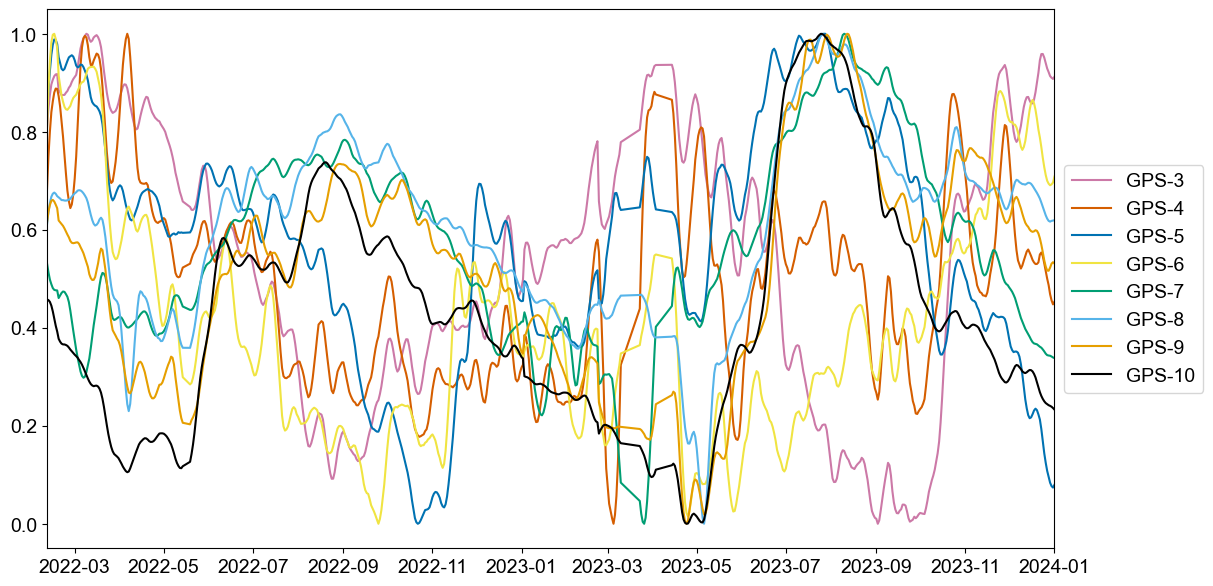

In [414]:
fig, ax = plt.subplots(figsize=(13,7))

start_time = pd.Timestamp('2022-01-01')
end_time = pd.Timestamp('2024-01-01')
plot_df = df[df.index.slice_indexer(start_time,end_time)]

# now scale and transform data so variables are of similar weight 
#(If you are developing a model that has a scientific value then you need to get rid of the units of the input variables. That’s because a model, if it is fundamental, should not depend on the particular units you use (https://www.quora.com/Should-you-standardise-data-before-regression))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # normalize between 0 and 1, has to be this when dataset is not normally distributed
plot_df = pd.DataFrame(scaler.fit_transform(plot_df),columns=columns, index=plot_df.index) # scale transform 0-1

ax.plot(plot_df.index, plot_df.iloc[:,0], color=colors[0], label=f'{columns[0]}')
ax.plot(plot_df.index, plot_df.iloc[:,1], color=colors[1], label=f'{columns[1]}')
ax.plot(plot_df.index, plot_df.iloc[:,2], color=colors[2], label=f'{columns[2]}')
ax.plot(plot_df.index, plot_df.iloc[:,3], color=colors[3], label=f'{columns[3]}')
ax.plot(plot_df.index, plot_df.iloc[:,4], color=colors[4], label=f'{columns[4]}')
ax.plot(plot_df.index, plot_df.iloc[:,5], color=colors[5], label=f'{columns[5]}')
ax.plot(plot_df.index, plot_df.iloc[:,6], color=colors[6], label=f'{columns[6]}')
ax.plot(plot_df.index, plot_df.iloc[:,7], color=colors[7], label=f'{columns[7]}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Creep burst analysis of GNSS 

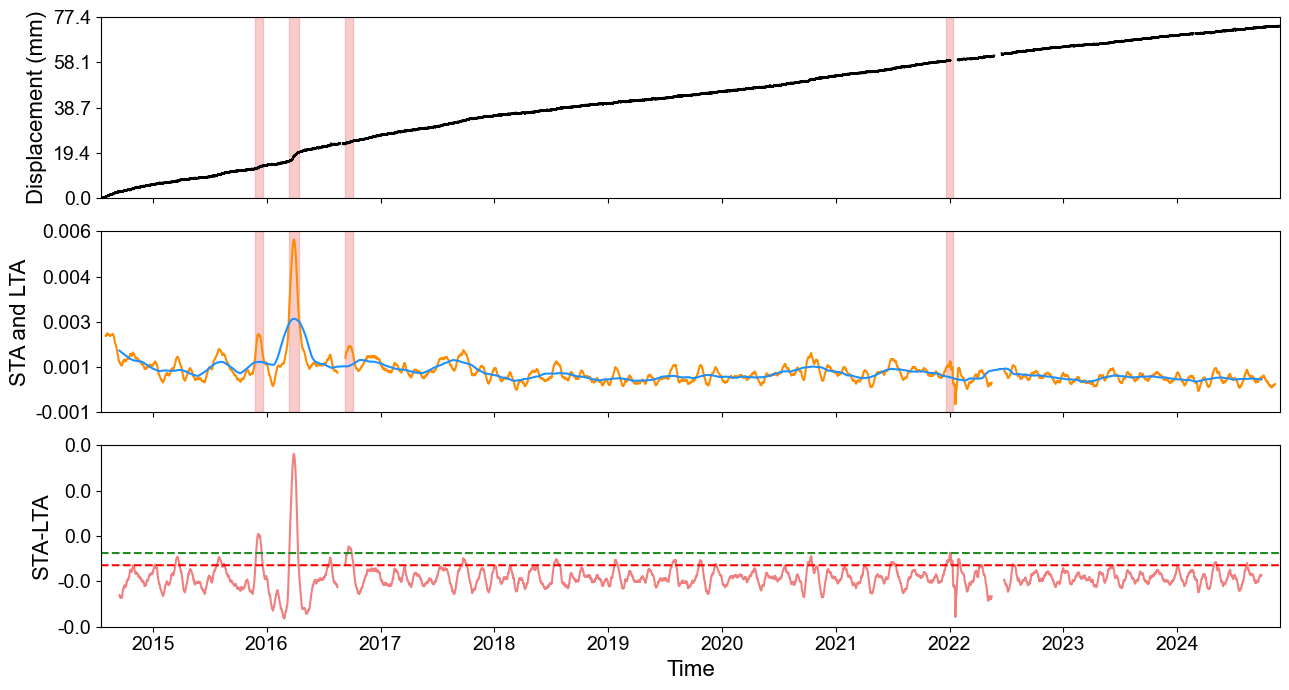

Number of creep bursts: 4


In [16]:
plot_df = JTT3Disp.copy() # load data to look at
# plot_df = JTT2DispLowerZone.copy() # load data to look at

# Plotting
fig, ax = plt.subplots(nrows=3, figsize=(13,7), sharex=True)

# ax.set_xlim(plot_df.index[0], plot_df.index[-1])

# df of start and end of bursts
window = []
previous_d = 0
for i, d in enumerate(plot_df['nBursts']):
    if d != previous_d:
        previous_d = d
        window.append(plot_df[i:i+1].index)
        
idx = np.arange(0, len(window), 2)  # index to slice at even numbers
for start in idx:
    st = [pd.Timestamp(i) for i in window[start]]
    end = [pd.Timestamp(i) for i in window[start+1]]
    ax[0].axvspan(xmin=st[0], xmax=end[0], ymin=0, ymax=1, facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=1, alpha=0.4)

# ax_yy.bar(plot_df.index, plot_df['nBursts'], width = 1*10**(-6*4), color='lightcoral', ec='lightcoral', label='Creep burst', alpha=0.4)
# ax[0].plot(plot_df.index, plot_df['2_days_velocity'], color='red', label='2 days velocity')
ax[0].plot(plot_df.index, plot_df.iloc[:,0]-plot_df.iloc[:,0][0], color='black', label='Displacement')

nticks = 5
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# ax_y.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
# ax_y.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
for start in idx:
    st = [pd.Timestamp(i) for i in window[start]]
    end = [pd.Timestamp(i) for i in window[start+1]]
    ax[1].axvspan(xmin=st[0], xmax=end[0], ymin=0, ymax=1, facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=1, alpha=0.4)

ax[1].plot(plot_df.index, plot_df['sta'], color='darkorange', label='STA') # linestyle = (0,(5, 10))
ax[1].plot(plot_df.index, plot_df['lta'], color='dodgerblue', label='LTA' )

nticks = 5
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# for start in idx:
#     st = [pd.Timestamp(i) for i in window[start]]
#     end = [pd.Timestamp(i) for i in window[start+1]]
#     ax[2].axvspan(xmin=st[0], xmax=end[0], ymin=0, ymax=1, facecolor='lightcoral', edgecolor='lightcoral', label='Creep burst', zorder=1, alpha=0.4)
ax[2].plot(plot_df.index, plot_df['sta-lta'], color='lightcoral', label='STA-LTA' ) # linestyle = (0,(5, 1))
ax[2].plot(plot_df.index, plot_df['trigger'], color='forestgreen', linestyle='--',label=r'mean LTA + 1.5$ \times \sigma$') # trigger
ax[2].plot(plot_df.index, plot_df['detrigger'], color='red', linestyle='--',label=r'mean LTA + 0.75$ \times \sigma$') # detrigger
# ax[2].axhline(threshold[0], color='forestgreen', linestyle='--',label='mean + 2$\sigma$') # trigger
# ax[2].axhline(threshold[1], color='red', linestyle='--',label='mean + $\sigma$') # detrigger

# ax[2].set_ylim(0,400)

nticks = 5
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# ax[0].set_ylabel('Velocity (mm/h)')
ax[0].set_ylabel('Displacement (mm)')
ax[1].set_ylabel('STA and LTA')
ax[2].set_ylabel('STA-LTA')
ax[2].set_xlabel('Time')

# generate legend

### THIS NEEDS A FIX ###

# to solve many creep burst legends
def unique(list1):
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

# # setting position of legend
# loc = 'lower right'
# bbox = (1.3, .15)

# lines, labels = ax[0].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
# ax[0].legend(lines, labels, loc=loc, bbox_to_anchor=bbox)

# lines, labels = ax[1].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
# ax[1].legend(lines, labels, loc=loc, bbox_to_anchor=bbox)

# lines, labels = ax[2].get_legend_handles_labels()
# lines = unique(lines)
# labels = unique(labels)
# ax[2].legend(lines, labels, loc=loc, bbox_to_anchor=bbox)

# ax_y.set_ylim(0, max(ax_y.get_ylim()))
# yabs_max = abs(max(ax[0].get_ylim(), key=abs))
# ax[0].set_ylim(ymin=-yabs_max, ymax=yabs_max)

ax[0].set_ylim(0, max(ax[0].get_ylim()))
ax[2].set_xlim(plot_df.index[0],plot_df.index[-1]) # remove space on each side of x-axis apearing when using sharex=True
fig.tight_layout()
plt.show()

# number of creep bursts
print(f'Number of creep bursts: {len(idx)}')

# # # saving
# path = 'plots\\'
# save_name = f'{path}STA_LTA_filt_entire_STA4LTA60days_Static.png'
# fig.savefig(save_name, dpi=300, bbox_inches='tight')

# GNSS Figure 2 warm / cold figure

In [16]:
# df = jtt_temp.copy()
# df = gam_temp.copy()

# df = jtt_xgeo_temp.copy()
df = gam_xgeo_temp.copy()

df = df.resample('D').mean()

# Ensure the temperature column is correctly indexed
temperature_column = 'temperature'

# Extract year and month from the DateTime index
df['year'] = df.index.year
df['month'] = df.index.month

# Permafrost index
# Group by year and month
days_above_zero_monthly = df[df[temperature_column] > 0].groupby(['year', 'month']).size().reset_index(name='days_above_zero')
days_below_zero_monthly = df[df[temperature_column] < 0].groupby(['year', 'month']).size().reset_index(name='days_below_zero')

# Group by year only
days_above_zero_yearly = df[df[temperature_column] > 0].groupby(['year']).size().reset_index(name='days_above_zero')
days_below_zero_yearly = df[df[temperature_column] < 0].groupby(['year']).size().reset_index(name='days_below_zero')


# # Choose whether to use monthly or yearly data
# use_monthly = False # off
use_monthly = True  # on 

if use_monthly:
    # Merge the monthly DataFrames
    merged_df = pd.merge(days_above_zero_monthly, days_below_zero_monthly, on=['year', 'month'], how='outer').fillna(0)
    # Create a 'date' column from 'year' and 'month'
    merged_df['date'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))
    # Set the 'date' column as the index
    merged_df.set_index('date', inplace=True)
    # Drop the now redundant 'year' and 'month' columns
    merged_df.drop(columns=['year', 'month'], inplace=True)
else:
    # Merge the yearly DataFrames
    merged_df = pd.merge(days_above_zero_yearly, days_below_zero_yearly, on=['year'], how='outer').fillna(0)
    # Create a 'date' column from 'year'
    merged_df['date'] = pd.to_datetime(merged_df['year'].astype(str) + '-01-01')
    # Set the 'date' column as the index
    merged_df.set_index('date', inplace=True)
    # Drop the now redundant 'year' column
    merged_df.drop(columns=['year'], inplace=True)

# Create the freeze index column
merged_df['freeze_index'] = merged_df['days_above_zero'] / (merged_df['days_below_zero'] + np.finfo(float).eps) # np.finfo(float).eps very smal value added to avoid dividing on zero

# Separate into warm and cold columns
merged_df['warm'] = merged_df['freeze_index'].apply(lambda x: x if x > 1 else np.nan)
merged_df['cold'] = merged_df['freeze_index'].apply(lambda x: x if x <= 1 else np.nan)

# Normalize warm and cold columns from 0 to 1
file = merged_df['warm']
merged_df['warm'] = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
file = merged_df['cold']
merged_df['cold'] = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))


# jett_freeze_index = merged_df.copy()
gam_freeze_index = merged_df.copy()
# plt.scatter(freeze_index.index, freeze_index['warm'], color=colors[1], label='Freeze index')
# plt.scatter(freeze_index.index, freeze_index['cold'], color=colors[2], label='Freeze index')

In [79]:
gam_freeze_index.head(12)

,days_above_zero,days_below_zero,freeze_index,warm,cold
date,,,,,
2010-01-01,148,216,0.685185,NaN,0.784444
2011-01-01,158,206,0.766990,NaN,0.892427
2012-01-01,133,232,0.573276,NaN,0.636724
2013-01-01,149,214,0.696262,NaN,0.799065
2014-01-01,140,224,0.625000,NaN,0.705000
2015-01-01,152,212,0.716981,NaN,0.826415
2016-01-01,168,198,0.848485,NaN,1.000000
2017-01-01,139,226,0.615044,NaN,0.691858
2018-01-01,165,197,0.837563,NaN,0.985584


year: 2021
min: 0.9312169312169312
median: 0.9312169312169312
max: 0.9312169312169312
 
year: 2022
min: 1.1927710843373494
median: 1.1927710843373494
max: 1.1927710843373494
 
year: 2023
min: 0.8860103626943006
median: 0.8860103626943006
max: 0.8860103626943006
 
year: 2024
min: 1.1294117647058823
median: 1.1294117647058823
max: 1.1294117647058823
 

Total stats per year
median : 1.0303143479614068
min : 0.8860103626943006
max : 1.1927710843373494


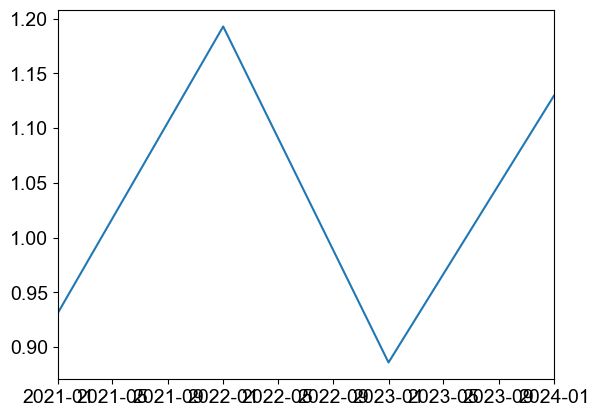

In [92]:
# Gamanjunni
start_time = '2021-01-01'
end_time = '2024-11-27'

df = jett_freeze_index.copy() # yearly

# df = gam_freeze_index.copy() # monthly

col_name = 'freeze_index'
df['year'] = df.index.year
df['month'] = df.index.month



df = df[df.index.slice_indexer(start_time,end_time)]
med = []
mini = []
maxi = []
for i,d in enumerate(df['year'].unique()):
    file = df[df['year'] == d]
    print(f'year: {d}')

    # # temp monthly stats
    # file = file.groupby(['month'])[col_name].sum().values
    # print(f'max: {np.nanmax(file)}')
    # print(f'median: {np.nanmedian(file)}')
    # print(f'min: {np.nanmin(file)}')
    # print(' ')
    # med.append(np.nanmedian(file))
    # temp stats
    print(f'min: {np.nanmin(file[col_name])}')
    print(f'median: {np.nanmedian(file[col_name])}')
    print(f'max: {np.nanmax(file[col_name])}')
    # print(f'cumulated: {np.nansum(file[col_name])}')
    print(' ')

    mini.append(np.nanmin(file[col_name]))
    maxi.append(np.nanmax(file[col_name]))
    med.append(np.nanmedian(file[col_name])) # max, river peak flow

# print('Total stats per data interval')
# print(f'max: {np.nanmax(df[col_name])}')
# print(f'min: {np.nanmin(df[col_name])}')
# print(f'median: {np.nanmedian(df[col_name])}')

print('\nTotal stats per year')
print('median :',np.nanmedian(med))
print('min :',np.nanmin(mini))
print('max :',np.nanmax(maxi))

plt.plot(df.loc[:,col_name])

In [69]:
file.head()

,days_above_zero,days_below_zero,freeze_index,warm,cold,year,month
date,,,,,,,
2024-01-01,0.0,31.0,0.000000,NaN,0.000000,2024,1
2024-02-01,0.0,29.0,0.000000,NaN,0.000000,2024,2
2024-03-01,0.0,31.0,0.000000,NaN,0.000000,2024,3
2024-04-01,3.0,27.0,0.111111,NaN,0.118519,2024,4
2024-05-01,20.0,11.0,1.818182,3.105519e-18,NaN,2024,5


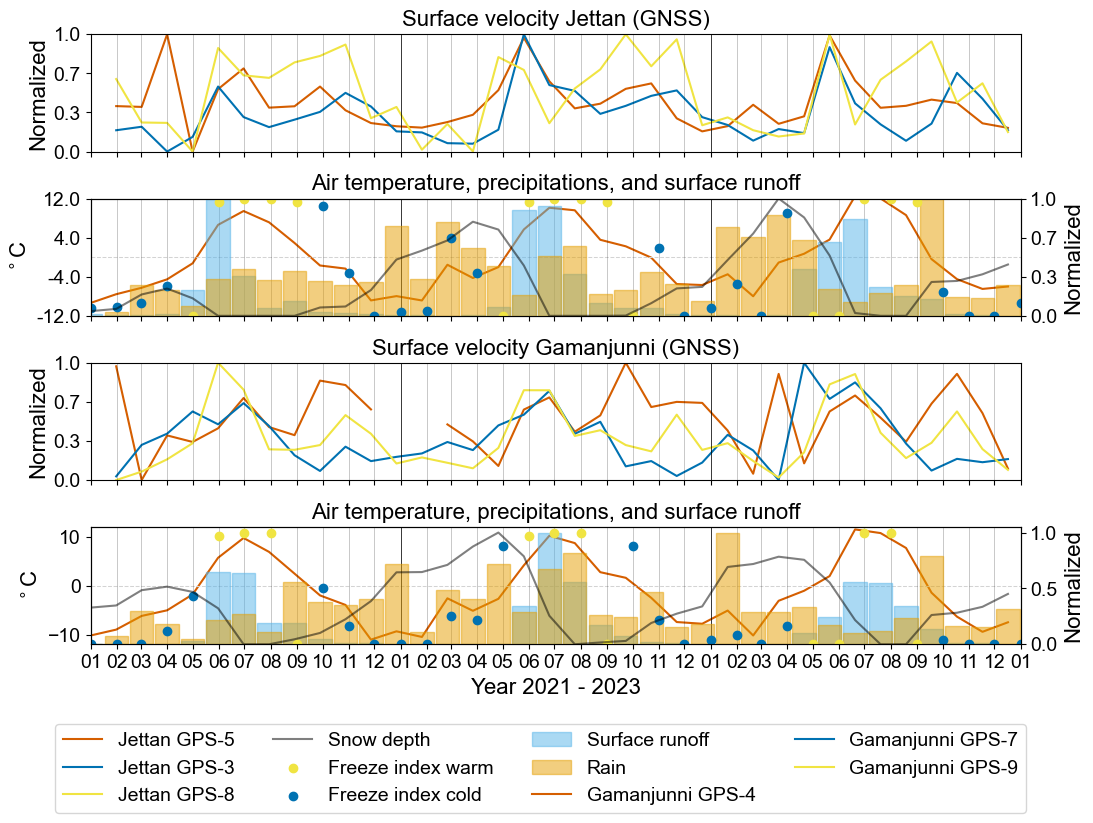

In [22]:
########### Cleaning DMS and GPS ############
from scipy.signal import savgol_filter

# rolling mean filter window
window_mean = 7 # 7 is enough to keep temp stationary

# savgol parameters
window_size = 11
poly_order = 3

def clean_lowpassfilt(file, colnmbr=0, name='Water table [m bgl]:'): # colnmbr is the column chosen to lowpass filter, name is wanted name for filtered column
    if isinstance(file,pd.DataFrame) == False:
        file = file.to_frame()
    file = file.resample('1D').median() # matching interval of cleaning parameters
    file = file.dropna()
    file['interpolated'] = file.iloc[:,colnmbr].interpolate(method='linear', limit_direction ='forward')
    # file['filt'] = butter_lowpass_filter(file.iloc[:,-1], cutoff, fs, order) # replace original by lowpass filtered
    file['filt'] = savgol_filter(file.iloc[:,-1], window_size, poly_order) # savitzky-golay filter
    # file['filt'] = file['filt'].rolling(window=window_mean, center=True).mean() # rolling mean
    file = file.dropna().reindex(file.index) # remove interpolated rows from df
    file = file.drop(file.columns[[0,1]], axis=1) # drop interpolated and original data column
    file.rename(columns={'filt':name}, inplace=True) # I call it the same as original if it was dependent on name in scripts lower down
    return file
######################################

# plotting
ncols = 1
nrows = 4 # len(file['event'].unique()) // ncols + (len(file['event'].unique()) % ncols > 0)

fig, ax = plt.subplots(nrows, ncols,figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace = .4)

# manually picked start and end times for following data
file3 = JTT1Disp.copy()
start_time = pd.Timestamp('2021-01-01')
end_time = pd.Timestamp('2024-01-01')
interval = 30 # down sampling days
vel_interval = 1 # smoothing window


vel_true = False # always on
seasonal = False # always on

# turn on velocity or seasonal decomposition
vel_true = True 
# seasonal = True

# Jettan
data = '2d'
df =  jtt_gps5 # Jtt1 gps 5 or gps 4
df =  df[df.index.slice_indexer(start_time,end_time)]
df = df[data].dropna()
df = clean_lowpassfilt(df, colnmbr=0, name=f'{data}')
df = df.resample(f'{interval}d').median() # downsampling with median value
if vel_true:
    df = diff_shift(df, vel_interval) # velocity
if seasonal:
    decomposed_series = STL(df.iloc[:,0], seasonal=13, period=12).fit() # for daily should be 13 and 365, monthly 13 and 12
    df = decomposed_series.seasonal
df.index = pd.to_datetime(df.index)
file = df.copy()
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[2].plot(file.index, file, color=colors[1], label='GPS 5')
ax[0].plot(file.index, normalized, color=colors[1], label='Jettan GPS-5')

df =  jtt_gps3 # same as Jtt2
df =  df[df.index.slice_indexer(start_time,end_time)]
df = df[data].dropna()
df = clean_lowpassfilt(df, colnmbr=0, name=f'{data}')
df = df.resample(f'{interval}d').median() # downsampling with median value
if vel_true:
    df = diff_shift(df, vel_interval) # velocity
if seasonal:
    decomposed_series = STL(df.iloc[:,0], seasonal=13, period=12).fit() # for daily should be 13 and 365, monthly 13 and 12
    df = decomposed_series.seasonal
df.index = pd.to_datetime(df.index)
file = df.copy()
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[2].plot(file.index, file, color=colors[2], label='GPS 3')
ax[0].plot(file.index, normalized, color=colors[2], label='Jettan GPS-3')

df =  jtt_gps8 # same as Jtt3
df =  df[df.index.slice_indexer(start_time,end_time)]
df = df[data].dropna()
df = clean_lowpassfilt(df, colnmbr=0, name=f'{data}')
df = df.resample(f'{interval}d').median() # downsampling with median value
if vel_true:
    df = diff_shift(df, vel_interval) # velocity
if seasonal:
    decomposed_series = STL(df.iloc[:,0], seasonal=13, period=12).fit() # for daily should be 13 and 365, monthly 13 and 12
    df = decomposed_series.seasonal
df.index = pd.to_datetime(df.index)
file = df.copy()
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[2].plot(file.index, file, color=colors[3], label='GPS 8')
ax[0].plot(file.index, normalized, color=colors[3], label='Jettan GPS-8')

# Met data
width = 55/60*interval # width of bars

temp_sub = jtt_temp[jtt_temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # actual air temp
temp_sub = temp_sub.resample(f'{interval}d').median()

ax[1].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax[1].axhline(y=0.0, color='lightgray', linestyle='dashed', linewidth=.75) # showing zero


# ST_sub = ST[ST.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
# ST_sub.iloc[:,0] = medfilt(ST_sub.iloc[:,0], kernel_size=n_day)
# ST_sub.iloc[:,1] = medfilt(ST_sub.iloc[:,1], kernel_size=n_day)

# snowrain_melt_sub =  snowrain_melt[(snowrain_melt.index > start_time) & (snowrain_melt.index < end_time)]
surfacerunoff_sub =  jtt_xgeo_surfacerunnoff[jtt_xgeo_surfacerunnoff.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
surfacerunoff_sub = surfacerunoff_sub.resample(f'{interval}d').sum()
file = surfacerunoff_sub.iloc[:,0]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file)) # normalized

ax_y1 = ax[1].twinx()
# ax_y3.bar(dates.date2num(file.index), file, width = width, ec=colors[5], color=colors[5], label='Surface runoff', alpha=0.5)
ax_y1.bar(dates.date2num(file.index), normalized, width = width, ec=colors[5], color=colors[5], label='Surface runoff', alpha=0.5)

xgeo_snow_sub =  jtt_xgeo_snow[jtt_xgeo_snow.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
xgeo_snow_sub = xgeo_snow_sub.resample(f'{interval}d').max()
file = xgeo_snow_sub.iloc[:,0]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file)) # normalized

# ax_y3.plot(file.index, file, color=colors[7], label='Snow depth', alpha=0.5)
ax_y1.plot(file.index, normalized, color=colors[7], label='Snow depth', alpha=0.5)

# xgeo_rain_sub =  jtt_precip[jtt_precip.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # actual rain measurement
xgeo_rain_sub =  jtt_xgeo_rain[jtt_xgeo_rain.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # xgeo rain
xgeo_rain_sub = xgeo_rain_sub.resample(f'{interval}d').sum()
file = xgeo_rain_sub.iloc[:,0]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file)) # normalized

# ax_y3.bar(dates.date2num(file.index), file, width = width, ec=colors[6], color=colors[6], label='Rain', alpha=0.5)
ax_y1.bar(dates.date2num(file.index), normalized, width = width, ec=colors[6], color=colors[6], label='Rain', alpha=0.5)

freeze_index_sub =  jett_freeze_index[jett_freeze_index.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
ax_y1.scatter(freeze_index_sub.index, freeze_index_sub['warm'], color=colors[3], label='Freeze index warm')
ax_y1.scatter(freeze_index_sub.index, freeze_index_sub['cold'], color=colors[2], label='Freeze index cold')

# ax[3].plot(ST_sub.index,ST_sub['ST2'], color=color_bacscarpairtemp, label='BS air temperature')
# ax[3].plot(ST_sub.index,ST_sub['ST3'], color=color_bacscarprocktemp, label='BS rock temperature')

# Gamanjunni
data = '2d'
df =  gam_gps4 # Jtt1 gps 5 or gps 4
df =  df[df.index.slice_indexer(start_time,end_time)]
df = df[data].dropna()
df = clean_lowpassfilt(df, colnmbr=0, name=f'{data}')
df = df.resample(f'{interval}d').median() # downsampling with median value
if vel_true:
    df = diff_shift(df, vel_interval) # velocity
if seasonal:
    decomposed_series = STL(df.iloc[:,0], seasonal=13, period=12).fit() # for daily should be 13 and 365, monthly 13 and 12
    df = decomposed_series.seasonal
df.index = pd.to_datetime(df.index)
file = df.copy()
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[2].plot(file.index, file, color=colors[1], label='GPS 5')
ax[2].plot(file.index, normalized, color=colors[1], label='Gamanjunni GPS-4')

df =  gam_gps7 # same as Jtt2
df =  df[df.index.slice_indexer(start_time,end_time)]
df = df[data].dropna()
df = clean_lowpassfilt(df, colnmbr=0, name=f'{data}')
df = df.resample(f'{interval}d').median() # downsampling with median value
if vel_true:
    df = diff_shift(df, vel_interval) # velocity
if seasonal:
    decomposed_series = STL(df.iloc[:,0], seasonal=13, period=12).fit() # for daily should be 13 and 365, monthly 13 and 12
    df = decomposed_series.seasonal
df.index = pd.to_datetime(df.index)
file = df.copy()
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[2].plot(file.index, file, color=colors[2], label='GPS 3')
ax[2].plot(file.index, normalized, color=colors[2], label='Gamanjunni GPS-7')

df =  gam_gps9 # same as Jtt3
df =  df[df.index.slice_indexer(start_time,end_time)]
df = df[data].dropna()
df = clean_lowpassfilt(df, colnmbr=0, name=f'{data}')
df = df.resample(f'{interval}d').median() # downsampling with median value
if vel_true:
    df = diff_shift(df, vel_interval) # velocity
if seasonal:
    decomposed_series = STL(df.iloc[:,0], seasonal=13, period=12).fit() # for daily should be 13 and 365, monthly 13 and 12
    df = decomposed_series.seasonal
df.index = pd.to_datetime(df.index)
file = df.copy()
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file))
# ax[2].plot(file.index, file, color=colors[3], label='GPS 8')
ax[2].plot(file.index, normalized, color=colors[3], label='Gamanjunni GPS-9')

# Met data
# temp_sub = gam_temp[gam_temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # actual air temp
temp_sub = gam_xgeo_temp[gam_xgeo_temp.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # xgeo air temp
temp_sub = temp_sub.resample(f'{interval}d').median()

ax[3].plot(temp_sub.index, temp_sub['temperature'], color=colors[1], label='Air temperature')
ax[3].axhline(y=0.0, color='lightgray', linestyle='dashed', linewidth=.75) # showing zero

surfacerunoff_sub =  gam_xgeo_surfacerunnoff[gam_xgeo_surfacerunnoff.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
surfacerunoff_sub = surfacerunoff_sub.resample(f'{interval}d').sum()
file = surfacerunoff_sub.iloc[:,0]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file)) # normalized

ax_y3 = ax[3].twinx()
# ax_y3.bar(dates.date2num(file.index), file, width = width, ec=colors[5], color=colors[5], label='Surface runoff', alpha=0.5)
ax_y3.bar(dates.date2num(file.index), normalized, width = width, ec=colors[5], color=colors[5], label='Surface runoff', alpha=0.5)

xgeo_snow_sub =  gam_xgeo_snow[gam_xgeo_snow.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
xgeo_snow_sub = xgeo_snow_sub.resample(f'{interval}d').max()
file = xgeo_snow_sub.iloc[:,0]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file)) # normalized

# ax_y3.plot(file.index, file, color=colors[7], label='Snow depth', alpha=0.5)
ax_y3.plot(file.index, normalized, color=colors[7], label='Snow depth', alpha=0.5)

# xgeo_rain_sub =  gam_precip[gam_precip.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # actual data
xgeo_rain_sub =  gam_xgeo_precip[gam_xgeo_precip.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))] # xgeo data
xgeo_rain_sub = xgeo_rain_sub.resample(f'{interval}d').sum()
file = xgeo_rain_sub.iloc[:,0]
normalized = (file-np.nanmin(file))/(np.nanmax(file)-np.nanmin(file)) # normalized

# ax_y3.bar(dates.date2num(file.index), file, width = width, ec=colors[6], color=colors[6], label='Rain', alpha=0.5)
ax_y3.bar(dates.date2num(file.index), normalized, width = width, ec=colors[6], color=colors[6], label='Rain', alpha=0.5)

freeze_index_sub =  gam_freeze_index[gam_freeze_index.index.slice_indexer(pd.Timestamp(start_time), pd.Timestamp(end_time))]
ax_y3.scatter(freeze_index_sub.index, freeze_index_sub['warm'], color=colors[3], label='Freeze index warm')
ax_y3.scatter(freeze_index_sub.index, freeze_index_sub['cold'], color=colors[2], label='Freeze index cold')


# adjusting gridlines
nticks = 4
ax[0].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[1].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax_y1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax[2].yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))
ax_y1.yaxis.set_major_locator(matplotlib.ticker.LinearLocator(nticks))

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f')) # number of digits
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax_y1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# just to get an whole number so it looks nice
def myround(x, base=10):
    return base * round(x/base)

ymin, ymax = ax[0].get_ylim()
ax[0].set_ylim(0, 1) # velocity

ymin, ymax = ax[1].get_ylim()
# ymax = 24
ax[1].set_ylim(myround(-ymax, base=6), myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

ymin, ymax = ax_y1.get_ylim()
# ax_y3.set_ylim(0, 700) # available surface water, 1800 for two months, 1000 for 1 month
ax_y1.set_ylim(0,1)

ymin, ymax = ax[1].get_ylim()
ax[2].set_ylim(0, 1) # velocity

ymin, ymax = ax[3].get_ylim()
# ymax = 24
ax[3].set_ylim(myround(-ymax, base=6), myround(ymax, base=6)) # temp -12 bas 6 for two months, 16 and base 8 for 1 month

# ymin, ymax = ax_y1.get_ylim()
# # ax_y3.set_ylim(0, 700) # available surface water, 1800 for two months, 1000 for 1 month
# ax_y1.set_ylim(0,1)

if vel_true:
    ax[0].title.set_text('Surface velocity Jettan (GNSS)')
    ax[1].title.set_text('Air temperature, precipitations, and surface runoff')
    ax[2].title.set_text('Surface velocity Gamanjunni (GNSS)')
    ax[3].title.set_text('Air temperature, precipitations, and surface runoff')
else:
    ax[0].title.set_text('Surface displacement Jettan (GNSS)')
    ax[1].title.set_text('Air temperature, precipitations, and surface runoff')
    ax[2].title.set_text('Surface displacement Gamanjunni (GNSS)')
    ax[3].title.set_text('Air temperature, precipitations, and surface runoff')

#legend underneath plots
handles, labels = [(a + c + d) for a, c, d, in zip(ax[0].get_legend_handles_labels(),ax_y1.get_legend_handles_labels(), ax[2].get_legend_handles_labels())]
fig.subplots_adjust(bottom=0.27) # create space
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 0.2), ncol=4) # center of fig

# set axis labels
ax[0].set_ylabel('Normalized')
ax[2].set_ylabel('Normalized')
ax[1].set_ylabel('$^\circ$C')
ax_y1.set_ylabel('Normalized') #  per 2 months
ax[3].set_ylabel('$^\circ$C')
ax_y3.set_ylabel('Normalized') #  per 2 months
ax[3].set_xlabel('Years')
# else:
#     # set axis labels
#     ax[0].set_ylabel('mm/day')
#     ax[2].set_ylabel('mm/day')
#     ax[1].set_ylabel('$^\circ$C')
#     ax_y1.set_ylabel('mm') #  per 2 months
#     ax[3].set_xlabel('Years')

years = mdates.MonthLocator()   # set number for every other year
years_fmt = mdates.DateFormatter('%m') # only display year, not day and month
ax[3].set_xlabel(f'Year {start_time.year} - {end_time.year-1}')

ax[3].xaxis.set_major_locator(years)
ax[3].xaxis.set_major_formatter(years_fmt)

# Add a vertical line for each year
for i in range(nrows):
    for year in range(file.index.year.min(), file.index.year.max()+1):
        ax[i].axvline(pd.Timestamp(f'{year}-01-01'), color='black', linewidth=0.5)

# Add vertical line for each month with transparancy
for i in range(nrows):
    for year in range(file.index.year.min(), file.index.year.max() + 1):
        for month in range(1, 13):
            ax[i].axvline(pd.Timestamp(f'{year}-{month:02d}-01'), color='black', linewidth=0.5, alpha=0.3)

# removing tick labels from the xaxis
n = 1  # keeps every n row
[l.set_visible(False) for (i,l) in enumerate(ax[3].xaxis.get_ticklabels()) if i % n != 0]

# removing space on sides
ax[1].set_xlim(pd.Timestamp(start_time), pd.Timestamp(end_time))

# # adding the rectangles
# # Get start-stop pairs where column is not NaN
# def get_intervals(series):
#     is_valid = series.notna()
#     intervals = []
#     start = None
#     for i, valid in enumerate(is_valid):
#         if valid and start is None:
#             start = series.index[i]
#         elif not valid and start is not None:
#             end = series.index[i]
#             intervals.append((start, end))
#             start = None
#     if start is not None:
#         # Extend slightly beyond last timestamp using a time delta
#         end = series.index[-1] + (series.index[-1] - series.index[-2])
#         intervals.append((start, end))
#     return intervals


# intervals = get_intervals(freeze_index_sub['warm']) 
# for start, end in intervals:
#     ax[3].axvspan(start, end, ymin=0, ymax=1, facecolor='darkorange', alpha=0.3)

# intervals = get_intervals(freeze_index_sub['cold'])
# for start, end in intervals:
#     ax[3].axvspan(start, end, ymin=0, ymax=1, facecolor='dodgerblue', alpha=0.3)

# fig.tight_layout()
plt.show()

# saving
path = 'plots/'
save_name = f'{path}Figure9.png'
fig.savefig(save_name, dpi=600)

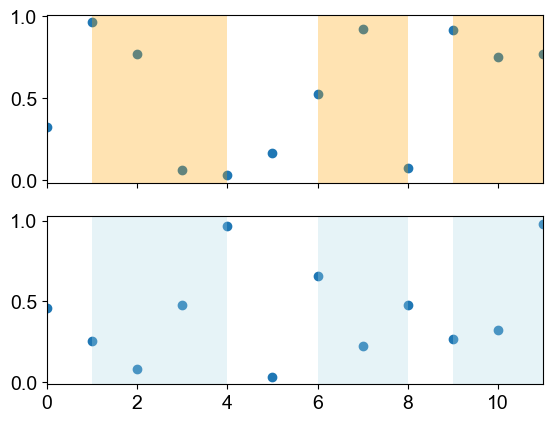

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample time-like index (e.g., months)
index = np.arange(12)

# Simulated flag column (non-NaN = active period)
flag = [np.nan, 1, 1, 1, np.nan, np.nan, 2, 2, np.nan, 3, 3, np.nan]
df = pd.DataFrame({'flag': flag}, index=index)

# Simulated data
df["val1"] = np.random.rand(len(df))
df["val2"] = np.random.rand(len(df))

# Plot setup
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.scatter(df.index, df["val1"])
ax2.scatter(df.index, df["val2"])

# Function to find stretches of non-NaN values
def get_intervals(series):
    is_valid = series.notna()
    intervals = []
    start = None
    for i, valid in enumerate(is_valid):
        if valid and start is None:
            start = series.index[i]
        elif not valid and start is not None:
            end = series.index[i]
            intervals.append((start, end))
            start = None
    # Catch if the last value was part of a run
    if start is not None:
        intervals.append((start, series.index[-1] + 1))  # extend past last index
    return intervals

# Get start-stop pairs where flag is not NaN
intervals = get_intervals(df["flag"])

# Plot rectangles per axis
for start, end in intervals:
    ax1.axvspan(start, end, ymin=0, ymax=1, facecolor='orange', alpha=0.3)
    ax2.axvspan(start, end, ymin=0, ymax=1, facecolor='lightblue', alpha=0.3)

# Set limits
ax1.set_xlim(df.index.min(), df.index.max())

plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\andregas\\UiO Dropbox\\Andreas Aspaas\\PhD_local\\PhD_work\\Dataanalysis_project\\MonitoringData\\Jettan\\plots\\crosscorr_Int_deformation_dv\\v(%)_lag6.png'

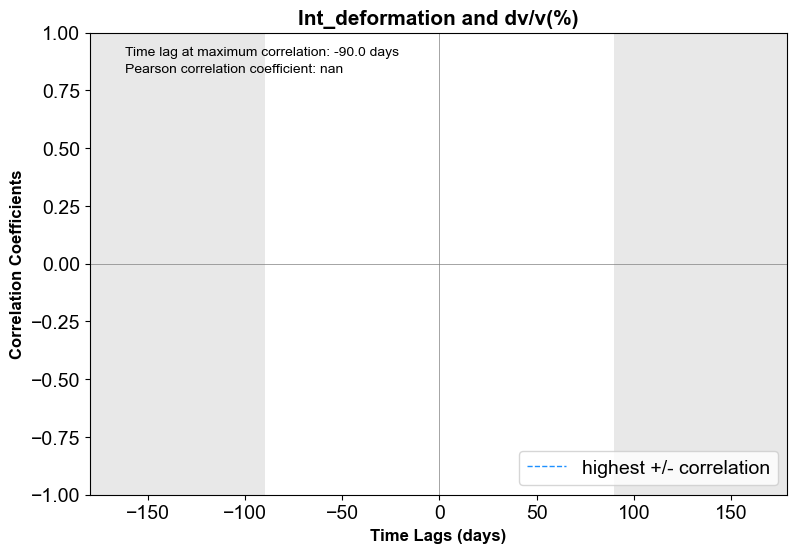

In [85]:
# This method is good. Same outcome as for statsmodels ccf

# Do correlations on stationary variables!

crosscorr_lag = 6 # tried 3 months did not work, tried 12 months = too much. Try 6 months now and only look at 3 months by graying out the boarders.

series1 = df.iloc[:,0] # seasonal disp
series2 = df.iloc[:,1] # seasonal wp

# series1 = df.iloc[:,0] # seasonal disp
# series2 = df.iloc[:,3] # seasonal rock temp

# Set the maximum lag you want to consider
h = 1 # NB !frequency per day! 
n_months = crosscorr_lag
period =h*90 # we assume correlation should happen within 90 days
max_lag = n_months*30*h
lags = range(-max_lag, max_lag)

# Initialize arrays to store results
correlation_coefficients = []
p_values = []

# Loop through different time lags (both positive and negative)
for lag in lags:
    # Calculate Pearson correlation coefficient and p-value
    if lag < 0:
        correlation_coefficient, p_value = pearsonr(series1[:lag], series2[-lag:])
    elif lag == 0:
        correlation_coefficient, p_value = pearsonr(series1, series2)
    else:
        correlation_coefficient, p_value = pearsonr(series1[lag:], series2[:-lag])
    
    # Append results to arrays
    correlation_coefficients.append(correlation_coefficient)
    p_values.append(p_value)

# # Find the lag with the maximum absolute correlation for entire time series
# max_corr_index = np.argmax(np.abs(correlation_coefficients))
# max_corr_lag = lags[max_corr_index]

# Find the lag with the maximum absolute correlation within +/- 3 months
corr_window = correlation_coefficients[period:period*3]
max_corr_index = np.argmax(np.abs(corr_window))
max_corr_lag = lags[period:period*3][max_corr_index]

n_std = 2
small_size = 10

import scipy.stats as st 
def ccf_plot(lags, ccf):
    fig, ax =plt.subplots(figsize=(9, 6))
    ax.plot(lags, ccf, color='black', lw=1)
    ax.axvline(x = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = 0, color = 'gray', lw = 0.5)
    ax.axhline(y = np.max(ccf), color = 'dodgerblue', lw = 1, linestyle='--', label = 'highest +/- correlation')
    ax.axhline(y = np.min(ccf), color = 'dodgerblue', lw = 1, linestyle='--')
    ax.plot(max_corr_lag/h, corr_window[max_corr_index], color='red', marker='o', markersize=4, alpha=0.5) # zorder=0 # point to highlight max within corr_window # point to highlight max within corr_window
    
    # # 2 x std
    # ax.axhline(y = np.mean(ccf)+n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--', label = f'{n_std} x std')
    # ax.axhline(y = np.mean(ccf)-n_std*np.std(ccf), color = 'darkorange', lw = 1, linestyle='--')
    # # # 1 x std
    # # ax.axhline(y = np.mean(ccf)+1*np.std(ccf), color = 'red', lw = 1, linestyle='--', label = f'{1} x std')
    # # ax.axhline(y = np.mean(ccf)-1*np.std(ccf), color = 'red', lw = 1, linestyle='--')
    
    # gray out area
    ax.axvspan(lags_plot[0], -90, facecolor='lightgray', alpha=0.5)
    ax.axvspan(+90,lags_plot[-1], facecolor='lightgray', alpha=0.5)
    
    # text in the plot
    y_pos = lags_plot[0]-(lags_plot[0]*0.1)
    ax.text(y_pos, 0.90, f'Time lag at maximum correlation: {max_corr_lag/h:.1f} days', horizontalalignment='left', color='k', fontsize=small_size)
    ax.text(y_pos, 0.83, f'Pearson correlation coefficient: {corr_window[max_corr_index]:.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    # ax.text(y_pos, 0.76, f'2 x standard deviation: +{np.mean(ccf)+n_std*np.std(ccf):.2f}/{np.mean(ccf)-n_std*np.std(ccf):.2f}', horizontalalignment='left', color='k', fontsize=small_size)
    pval = []
    # if p_values[max_corr_index] < 0.001:
    #     ax.text(y_pos, 0.69, f'P-value: <0.001', horizontalalignment='left', color='k', fontsize=small_size)
    # else:
    #     ax.text(y_pos, 0.69, f'P-value: {p_values[max_corr_index]:.3f}', horizontalalignment='left', color='k', fontsize=small_size)
    
    # cosmetics
    ax.set(ylim = [-1, 1])
    ax.set_title(f'{series1.name} and {series2.name}', weight='bold', fontsize = 15)
    ax.set_ylabel('Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel('Time Lags (days)', weight='bold', fontsize = 12)
    
    plt.legend(loc='lower right')
    
    # saving
    path = 'plots\\'
    save_name = f'{path}crosscorr_{series1.name}_{series2.name}_lag{n_months}.png'
    fig.savefig(save_name, dpi=300, bbox_inches='tight')
    
# changing lags to days
lags_plot = np.linspace(lags[0]/h,lags[-1]/h, num=int(max_lag*2)) # days

ccf_plot(lags_plot, correlation_coefficients)

# the first variable (x) is leading if negative lage time, and second variable (y) is leading if positive lag time